In [1]:
import os
import scvi
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

scvi.settings.seed = 0
sc.set_figure_params(dpi=100, frameon=False, figsize=(5,5), facecolor='white')
sc.settings.n_jobs = 8

/Users/pax/miniconda3/envs/hDRG/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/Users/pax/miniconda3/envs/hDRG/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
Global seed set to 0


In [2]:
import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_20377/3659631106.py:9: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [60]:
sc_adata = sc.read_h5ad('./Results_h5ad/02_scRNA_hDRG_ready.h5ad')
bk_adata = sc.read_h5ad('./Results_h5ad/01_bulk_hDRG_ready.h5ad')

/Users/pax/miniconda3/envs/hDRG/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
bk_adata.var_names = bk_adata.var_names.astype(str)
bk_adata.var_names_make_unique()

In [61]:
bk_adata.X = bk_adata.layers['counts'].copy()
bulk = bk_adata.to_df().T
bk_meta = bk_adata.obs.copy()

In [6]:
sc_adata_r = sc_adata.raw.to_adata()
sc_adata_r.var_names = sc_adata_r.var_names.str.upper().astype(str)
sc_adata_r.layers['counts'] = sc_adata_r.X.copy()

In [7]:
%%R -i sc_adata_r,bulk,bk_meta -o musicRes

# Save
# Cell type identities are stored as an AnnotatedDataFrame
bk_df = new("AnnotatedDataFrame", data = bk_meta)

# Creating an ExpressionSet from the bulk matrix
bulkDataES <- Biobase::ExpressionSet(assayData=as.matrix(bulk), phenoData = bk_df)
bulk_nopain <- bulkDataES[,bulkDataES$`pain state`=='N']
bulk_pain <- bulkDataES[,bulkDataES$`pain state`=='P']

# Run MuSiC2 to deconvolve multi-conditions bulk RNA-seq data
musicRes <- MuSiC::music2_prop(bulk.control.mtx=exprs(bulk_nopain),bulk.case.mtx=exprs(bulk_pain),
                               sc.sce = sc_adata_r, clusters = 'NociceptiveType', samples = 'orig_ident',
                               select.ct=c('Endothelial', 'Fibroblast', 'Macrophage', 'NFs', 'Nociceptors', 'Pericytes', 'SGC', 'Schwann_M'),
                               n_resample=20, sample_prop=0.5,cutoff_c=0.05,cutoff_r=0.01) 

saveRDS(musicRes, file = "03_bulk_deconvolved.rds")

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


In [24]:
%%R -o prop_all
est.prop = musicRes$Est.prop
prop_all = cbind('proportion'=c(est.prop), 'sampleID'=rep(rownames(est.prop),times=ncol(est.prop)), 'celltype'=rep(colnames(est.prop), each=nrow(est.prop)))
prop_all = as.data.frame(prop_all)
prop_all$proportion = as.numeric(as.character(prop_all$proportion))

In [28]:
pain_dict = bk_adata.obs['pain state'].to_dict()
prop_all['PainState'] = prop_all.sampleID.map(pain_dict)

In [45]:
prop_all

,proportion,sampleID,celltype,PainState
0,0.000000,45T10L,Endothelial,N
1,0.000000,61T5L,Endothelial,N
2,0.035578,67T4R,Endothelial,N
3,0.000000,44T11R,Endothelial,N
4,0.000000,69T10L,Endothelial,N
...,...,...,...,...
395,0.031381,41T7R,Schwann_M,P
396,0.000000,42T7L,Schwann_M,P
397,0.000000,42T7R,Schwann_M,P
398,0.051276,45T11R,Schwann_M,P


In [83]:
prop_all.to_csv('03_bulk_deconvolved.csv', index=False)

In [2]:
prop_all = pd.read_csv('03_bulk_deconvolved.csv')

/Users/pax/miniconda3/envs/hDRG/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/pax/miniconda3/envs/hDRG/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/pax/miniconda3/envs/hDRG/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/pax/miniconda3/envs/hDRG/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

/Users/pax/miniconda3/envs/hDRG/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 76.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/pax/miniconda3/envs/hDRG/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 11.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/pax/miniconda3/envs/hDRG/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/pax/miniconda3/envs/hDRG/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 82.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/pax/miniconda3/envs/hDRG/l

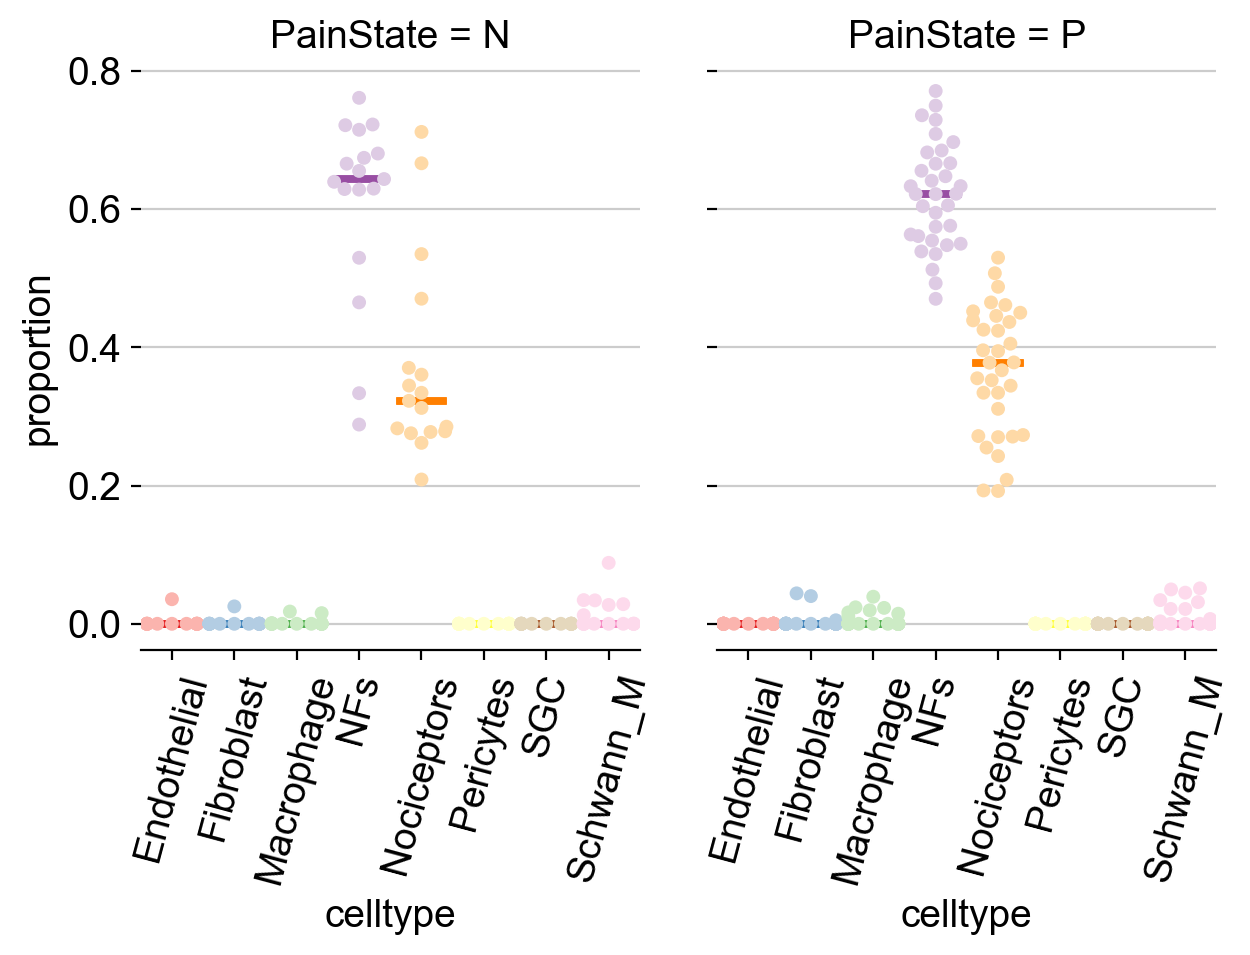

In [4]:
import seaborn as sns
g = sns.catplot(
    data=prop_all, x="celltype", y="proportion", hue="celltype", col="PainState",
    palette="Pastel1", errorbar="se",
    kind="swarm", height=5, aspect=0.65,
)

for i,v in enumerate(['N','P']):
    spec = dict(data=prop_all[prop_all.PainState == v], x="celltype", y="proportion", palette="Set1")
    sns.pointplot(**spec, join=False, ci=0, capsize=.7, scale=0, ax=g.axes[0,i], estimator='median')

g.despine(left=True)
g.set_xticklabels(rotation=75)
g.tight_layout()

/Users/pax/miniconda3/envs/hDRG/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/pax/miniconda3/envs/hDRG/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/pax/miniconda3/envs/hDRG/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/pax/miniconda3/envs/hDRG/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

/Users/pax/miniconda3/envs/hDRG/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 76.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/pax/miniconda3/envs/hDRG/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 11.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/pax/miniconda3/envs/hDRG/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/pax/miniconda3/envs/hDRG/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 82.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/pax/miniconda3/envs/hDRG/l

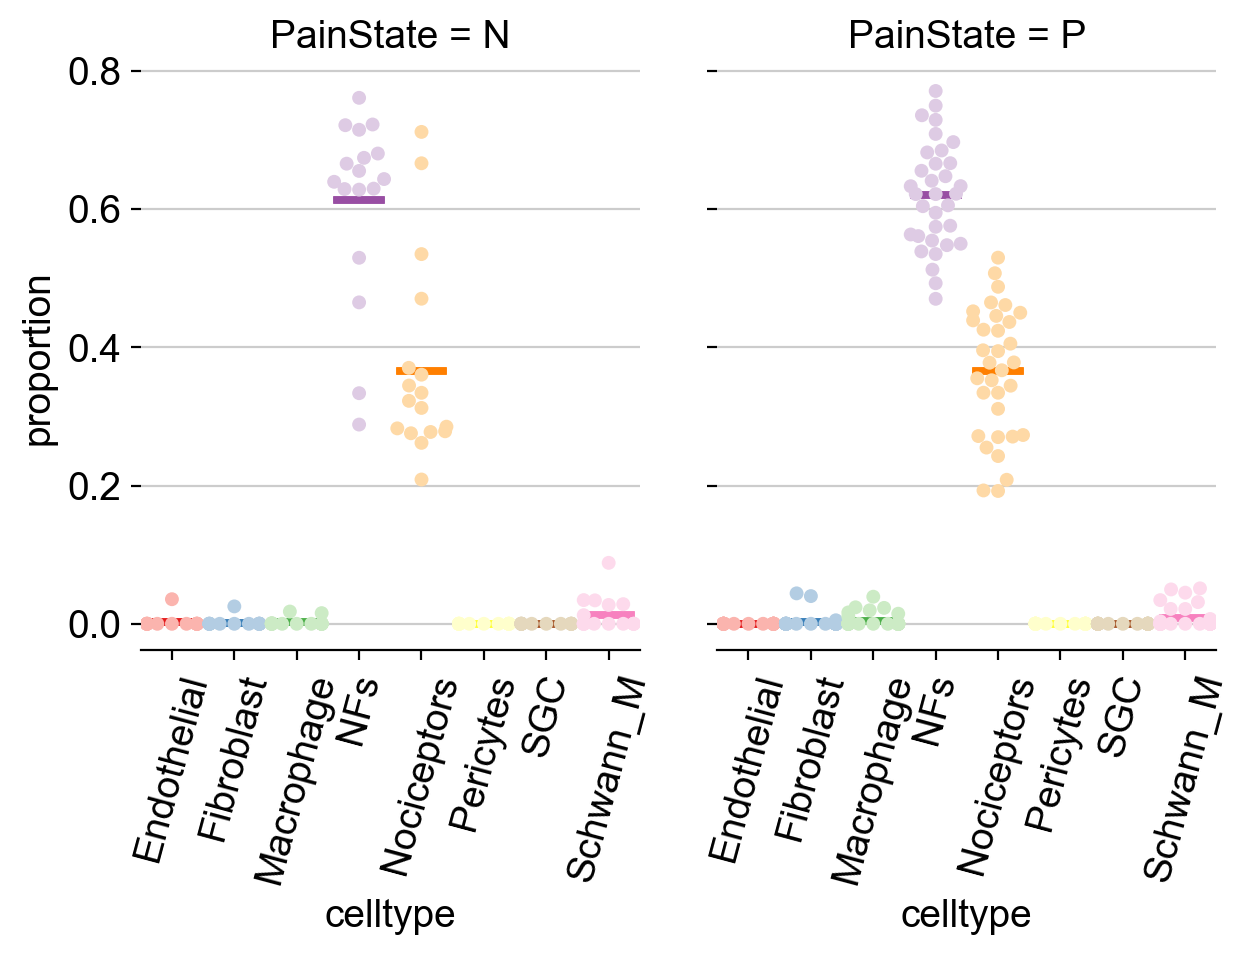

In [52]:
import seaborn as sns
g = sns.catplot(
    data=prop_all, x="celltype", y="proportion", hue="celltype", col="PainState",
    palette="Pastel1", errorbar="se",
    kind="swarm", height=5, aspect=0.65,
)

for i,v in enumerate(['N','P']):
    spec = dict(data=prop_all[prop_all.PainState == v], x="celltype", y="proportion", palette="Set1")
    sns.pointplot(**spec, join=False, ci=0, capsize=.7, scale=0, ax=g.axes[0,i], estimator='mean')

g.despine(left=True)
g.set_xticklabels(rotation=75)
g.tight_layout()

In [53]:
from scipy import stats

a = prop_all[(prop_all['celltype'] == 'Nociceptors') & (prop_all['PainState'] == 'N')].proportion
b = prop_all[(prop_all['celltype'] == 'Nociceptors') & (prop_all['PainState'] == 'P')].proportion
stats.ttest_ind(a, b, equal_var=False, alternative='less', random_state=42)

TtestResult(statistic=0.1386656314162616, pvalue=0.5545432547535567, df=23.151465998307238)